In [2]:
from sklearn.feature_extraction.text import *
from sklearn.naive_bayes import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.metrics import *
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('GVCEH Milestone 2 Labelling 1 - RawData.csv', usecols=['text', 'Relevant to Victoria', 'Relevant to Homelessness'])
df = df.rename(columns={"Relevant to Victoria": "vic", "Relevant to Homelessness": "hl"})
df.head()

,vic,hl,text
0,Yes,No,@AnnaGreenwoodL1 @saanich Dawson Heights Housi...
1,No,No,It's Election Day and the polls are now open u...
2,No,No,Sidney Bulwer Michaelia Roger #彩票 Bblythe Camp...
3,No,No,Me telling my parents I’m gonna spit on this o...
4,No,No,WRD Director Joy Langford shared water conserv...


In [4]:
print(df.shape)
df.dropna(inplace=True)
df = df[np.logical_and(df.vic.isin(['Yes', 'No']), df.hl.isin(['Yes', 'No']))]
df.shape

(2116, 3)


(788, 3)

In [5]:
df.vic.value_counts(), df.hl.value_counts()

(No     584
 Yes    204
 Name: vic, dtype: int64, No     684
 Yes    104
 Name: hl, dtype: int64)

In [6]:
label_map = dict(Yes=1, No=0)
label_map

{'Yes': 1, 'No': 0}

In [7]:
df.vic = df.vic.map(label_map)
df.hl = df.hl.map(label_map)

In [8]:
df = df.sample(frac=1., random_state=42)
train = df.iloc[:500]
test = df.iloc[500:]

In [9]:
train_x = train['text']
train_y = train[['vic', 'hl']]
test_x = test['text']
test_y = test[['vic', 'hl']]

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1,1))
train_feat = vectorizer.fit_transform(train_x)
test_feat = vectorizer.transform(test_x)

In [11]:
clf = RandomForestClassifier().fit(train_feat, train_y)
preds = clf.predict(test_feat)
print(multilabel_confusion_matrix(test_y, preds))
for i in [0, 1]:
  print(test_y.columns[i])
  print(classification_report(test_y.values[:,i], preds[:,i]))

[[[206   9]
  [ 35  38]]

 [[251   2]
  [ 33   2]]]
vic
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       215
           1       0.81      0.52      0.63        73

    accuracy                           0.85       288
   macro avg       0.83      0.74      0.77       288
weighted avg       0.84      0.85      0.84       288

hl
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       253
           1       0.50      0.06      0.10        35

    accuracy                           0.88       288
   macro avg       0.69      0.52      0.52       288
weighted avg       0.84      0.88      0.83       288



In [12]:
clf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced', max_features=1.0).fit(train_feat, train_y)
threshs = [0.45, 0.33]
preds = np.array(clf.predict_proba(test_feat))[:,:,1].T >= threshs
print(multilabel_confusion_matrix(test_y, preds))
for i in [0, 1]:
  print(test_y.columns[i])
  print(classification_report(test_y.values[:,i], preds[:,i]))

[[[193  22]
  [ 18  55]]

 [[221  32]
  [ 13  22]]]
vic
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       215
           1       0.71      0.75      0.73        73

    accuracy                           0.86       288
   macro avg       0.81      0.83      0.82       288
weighted avg       0.86      0.86      0.86       288

hl
              precision    recall  f1-score   support

           0       0.94      0.87      0.91       253
           1       0.41      0.63      0.49        35

    accuracy                           0.84       288
   macro avg       0.68      0.75      0.70       288
weighted avg       0.88      0.84      0.86       288



In [32]:
print(df.vic.value_counts()); print(df.hl.value_counts()); print(np.logical_and(df.vic, df.hl).sum())

0    584
1    204
Name: vic, dtype: int64
0    684
1    104
Name: hl, dtype: int64
93


In [22]:
(preds.sum(1) == 2).sum()

50

In [24]:
test = test.reset_index().drop('index', axis=1)
test.loc[test.sum(1) == 2].shape

<ipython-input-24-7d9f3f072626>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test.loc[test.sum(1) == 2].shape


(31, 3)

In [36]:
pred_idx = test.loc[(preds.sum(1) == 2)].index 
real_idx = test.loc[test.sum(1) == 2].index
sum(p in real_idx for p in pred_idx)

<ipython-input-36-38a18288c511>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  real_idx = test.loc[test.sum(1) == 2].index


19

After predicting with a low (recall-oriented) threshold, we have 50 tweets which are supposedly both HL and VIC. 19 of which are TP (out of the original 31 in the test set) and the other 31 are FP.

Let's visually inspect:

In [25]:
test.loc[(preds.sum(1) == 2)]

,vic,hl,text
7,1,1,"""Greater Victorians gave housing in the region..."
23,1,0,City of Victoria MNP Governance Review Recomme...
26,1,0,Greater Victoria Placemaking Network: great pe...
28,0,1,"In Victoria, house prices in Gippsland’s Venus..."
30,1,0,‼️Audit the BC poverty industry NOW‼️When they...
33,1,1,Update: thank you everyone for reaching out wi...
48,1,0,@CTVWarrenDean is hosting: Mornings With @alf...
50,1,0,‼️ Audit the BC poverty industry NOW ‼️Politic...
51,1,1,"the state of housing in Victoria is such that,..."
55,0,0,Great piece on housing affordability in the Ag...


In the original dataset, we had 93 relevant tweets out of 788. In the test set, we had 31 relevant tweets out of 288. In this new filtered dataset (based on the test set) that had been run through the relevance model, we would have 19 relevant tweets out of 50.

$R_o = 31/288=0.107$

$R_n = 19/50=0.38$

So our relevance rate almost quadrupled.

All in all, we went down from 31 relevant tweets to 19 relevant tweets (dropped 39%), and from 257 irrelevant tweets to 31 irrelevant tweets (dropped 88%).

There is an added advantage where the false positives are likely to be more relevant than completely irrelevant tweets (even if they don't meet our threshold for the relevant category).

Options to explore:
* Data cleaning (removing hashtags? URLs? emojis?)
* Featurization - improving upon basic tf-idf
* Different models (sklearn, xgboost, catboost, lightgbm etc)
* Hyperparameter tuning with CV

vic
0.40606060606060607 0.9178082191780822 0.37268576172685763 0.17
0.41875 0.9178082191780822 0.38433219178082195 0.18
0.42038216560509556 0.9041095890410958 0.38007154698542883 0.19
0.423841059602649 0.8767123287671232 0.3715866823913635 0.2
0.43537414965986393 0.8767123287671232 0.38169788463330534 0.21
0.4413793103448276 0.8767123287671232 0.3869626830420406 0.22
0.460431654676259 0.8767123287671232 0.40366610820932297 0.23
0.4666666666666667 0.863013698630137 0.40273972602739727 0.24
0.48091603053435117 0.863013698630137 0.4150371222419743 0.25
0.4881889763779528 0.8493150684931506 0.41462625391004204 0.26
0.5040650406504065 0.8493150684931506 0.42811003452500274 0.27
0.5081967213114754 0.8493150684931506 0.4316191331686503 0.28
0.5299145299145299 0.8493150684931506 0.4500643952698747 0.29
0.5350877192982456 0.8356164383561644 0.44712809420812305 0.3
0.5504587155963303 0.821917808219178 0.45243182103807966 0.31
0.5566037735849056 0.8082191780821918 0.4498578444042388 0.32
0.568627

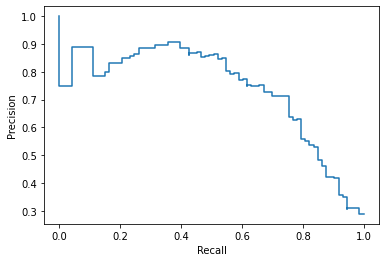

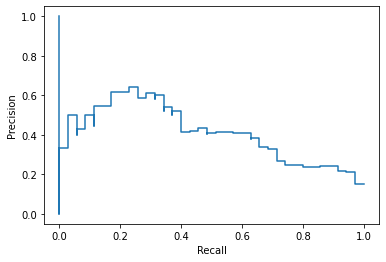

In [13]:
for i in [0, 1]:
  print(test_y.columns[i])
  precision, recall, thresh = precision_recall_curve(test_y.values[:,i], np.array(clf.predict_proba(test_feat))[:,:,1].T[:,i])
  for p, r, t in zip(precision, recall, thresh):
    if r > 0.4 and p > 0.4:
      print(p, r, p*r, t)
  disp = PrecisionRecallDisplay(precision=precision, recall=recall)
  disp.plot()